In [1]:
!nvidia-smi

Mon Apr 19 14:36:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import matplotlib.pyplot as plt
import os
import random
import sklearn
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
from glob import glob
import csv
import pandas as pd
import zipfile

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# train_data = []

# train_csv_path = '/content/drive/MyDrive/SKI/Second_task/train_regression.csv'
# with open(train_csv_path, "r") as file_obj:
#     reader = csv.reader(file_obj)
#     for row in reader:
#         # print(row)


In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/SKI/Second_task/train_regression.csv', names=np.arange(0, 257))
test_df = pd.read_csv('/content/drive/MyDrive/SKI/Second_task/test_regression.csv', names=np.arange(0, 256))


In [6]:
y_train = train_df.pop(256).values
x_train = train_df.values
x_test = test_df.values

x_train.shape, y_train.shape, x_test.shape

((1000, 256), (1000,), (100, 256))

# **Normalize data and make Dataloader**

In [7]:
# Среднее значение
mean = x_train.mean(axis=0)
# Стандартное отклонение
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std
y_train /= 1000

In [8]:
X_train = torch.tensor(x_train)
Y_train = torch.tensor(y_train)
X_test = torch.tensor(x_test)

In [9]:
validation_size = 100

from torch.utils.data import  DataLoader, TensorDataset
def data_loaders(x, y):
    x_train = x[0:len(x) - validation_size].clone()
    y_train = y[0:len(y) - validation_size].clone()
    x_valid = x[len(x) - validation_size: len(x)].clone()
    y_valid = y[len(y) - validation_size: len(y)].clone()
    dataset_train = TensorDataset(x_train, y_train)
    dataset_valid = TensorDataset(x_valid, y_valid)

    loader_train = DataLoader(
        dataset_train,
        batch_size=20,
        shuffle=True,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=20,
        drop_last=True,
    )

    return loader_train, loader_valid

In [10]:
loader_train, loader_valid = data_loaders(X_train, Y_train)

# **Net**

In [11]:
class Net3T(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(Net3T, self).__init__()
        self.fc1 = torch.nn.Linear(256, n_hidden_neurons)
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = x.view(-1)
        return x

In [12]:
class Net3R(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(Net3R, self).__init__()
        self.fc1 = torch.nn.Linear(256, n_hidden_neurons)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = x.view(-1)
        return x

In [13]:
class Net3S(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(Net3S, self).__init__()
        self.fc1 = torch.nn.Linear(256, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = x.view(-1)
        return x

In [14]:
class Net2R(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(Net2R, self).__init__()
        self.fc1 = torch.nn.Linear(256, n_hidden_neurons)
        self.act1 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc3(x)
        x = x.view(-1)
        return x

In [15]:
model = Net3R(100)
print(model(torch.randn(10, 256)).shape)
assert tuple(model(torch.randn(10, 256)).shape) == (10,)
print("Success!")

torch.Size([10])
Success!


In [16]:
rmse = {}
mae = {}
losses = {}

In [17]:
def train(model, 
          lr,
          weight_decay,
          max_epoch,
          loader_train, 
          loader_valid):
    device = torch.device('cuda:0' 
                      if torch.cuda.is_available() 
                      else 'cpu')
    
    def MAE(pred, target):
        res = float((pred - target).abs().sum())/len(pred)
        return res
      
    def RMSE(pred, target):
        res = (float(((pred - target).abs()**2).sum())/len(pred))**0.5
        return res


    criterion = torch.nn.MSELoss()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=weight_decay)

    test_rmse_history = []
    test_mae_history = []
    test_loss_history = [] 

    for epoch in range(max_epoch):

        for x_train, y_test in loader_train:
            model.train()
            torch.cuda.empty_cache()
            
            x_train = x_train.to(device = 'cuda', dtype=torch.float)
            y_test = y_test.to(device = 'cuda', dtype=torch.float)

            optimizer.zero_grad()
            preds = model(x_train)
            # print(preds)
            loss = criterion(preds, y_test)
            loss.backward()
            optimizer.step()
        print('epoch = ', epoch, '   ', 'loss = ', criterion(model(X_train.to(device = 'cuda',dtype=torch.float))*1000, Y_train.to(device = 'cuda',dtype=torch.float)*1000))
        rmse = 0
        mae = 0
        test_loss = 0
        n = 0
        for X_test, y_test in loader_valid:
            X_test = X_test.to(device = 'cuda', dtype=torch.float)
            y_test = y_test.to(device = 'cuda', dtype=torch.float)
            model.eval()

            test_preds = model(X_test)

            mae += MAE(test_preds, y_test)
            rmse += RMSE(test_preds, y_test)
            test_loss += criterion(test_preds, y_test)
            n += 1
             
        test_loss_history.append(test_loss/n)
        # print('epoch = ', epoch, '   ', 'loss = '= test_loss/n)
        test_mae_history.append(mae/n)
        test_rmse_history.append(rmse/n)

        if (epoch > max_epoch//2) and (test_loss_history[epoch]-test_loss_history[epoch-1] > 0.1):
            break
    # torch.save(model.state_dict(), '/content/drive/MyDrive/SKI/First_task/ResNet/ResNet15.pt')
    # del model
    return model, test_mae_history, test_rmse_history, test_loss_history

# Models = {}
# n_neurons = 512

# Lr = 0.001
# Wd = 0.0001
# Epoch = 20

# for i in range(0, 2):
#     Models['ReLU '+ str(Lr)], mae['ReLU '+ str(Lr)], rmse['ReLU '+ str(Lr)], losses['ReLU '+ str(Lr)] = \
#         train(Net3R(n_neurons), Lr, Wd, Epoch+30*i, loader_train, loader_valid)
#     Lr /= 10
#     Wd /= 10   

# Lr = 0.001
# Wd = 0.0001
# Epoch = 40
# for i in range(0, 2):
#     Models['Tanh '+ str(Lr)], mae['Tanh '+ str(Lr)], rmse['Tanh '+ str(Lr)], losses['Tanh '+ str(Lr)] = \
#         train(Net3T(n_neurons), Lr, Wd, Epoch+30*i, loader_train, loader_valid)
#     Lr /= 10
#     Wd /= 10   

  
# Lr = 0.001
# Wd = 0.0001
# Epoch = 30
# for i in range(0, 2):
#     Models['Sigmoid '+ str(Lr)], mae['Sigmoid '+ str(Lr)], rmse['Sigmoid '+ str(Lr)], losses['Sigmoid '+ str(Lr)] = \
#         train(Net3S(n_neurons), Lr, Wd, Epoch+30*i, loader_train, loader_valid)

#     Lr /= 10
#     Wd /= 10

# Lr = 0.001
# Wd = 0.0001
# Epoch = 20

# for i in range(0, 2):
#     Models['ReLU_2hl '+ str(Lr)], mae['ReLU_2hl '+ str(Lr)], rmse['ReLU_2hl '+ str(Lr)], losses['ReLU_2hl '+ str(Lr)] = \
#         train(Net2R(2*n_neurons), Lr, Wd, Epoch+30*i, loader_train, loader_valid)
#     Lr /= 10
#     Wd /= 10 

In [18]:
n_neurons = 512
Lr = 0.001
Wd = 0.0001
Epoch = 20
Model, mae['ReLU 0.001'], rmse['ReLU 0.001'], losses['ReLU 0.001'] = train(Net3R(n_neurons), Lr, Wd, Epoch, loader_train, loader_valid)

Lr = 0.0001
Wd = 0.00001
Epoch = 20
Model, mae['ReLU 0.001+'+ str(Lr)], rmse['ReLU 0.001+'+ str(Lr)], losses['ReLU 0.001+'+ str(Lr)] = \
        train(Model, Lr, Wd, Epoch, loader_train, loader_valid)

mae['ReLU 0.001'] += mae['ReLU 0.001+0.0001']
rmse['ReLU 0.001'] +=  rmse['ReLU 0.001+0.0001']
losses['ReLU 0.001'] += losses['ReLU 0.001+0.0001']

del mae['ReLU 0.001+0.0001'], rmse['ReLU 0.001+0.0001'], losses['ReLU 0.001+0.0001']

epoch =  0     loss =  tensor(2965.6711, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  1     loss =  tensor(494.4890, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  2     loss =  tensor(92.2334, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  3     loss =  tensor(50.9925, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  4     loss =  tensor(36.2052, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  5     loss =  tensor(28.2330, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  6     loss =  tensor(23.7453, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  7     loss =  tensor(20.7203, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  8     loss =  tensor(18.3402, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  9     loss =  tensor(16.8866, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  10     loss =  tensor(15.3648, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  11     loss =  tensor(14.4048, device='cuda:0', grad_fn=<MseLossBackward>)

3.644892058218829e-05 39.0


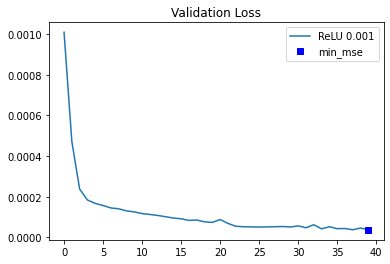

In [19]:
# colors = ['Red', 'Green']
i = 0
min = 1.0
min_epoch = 0
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
    if np.min(losses[experiment_id]) < min:
        min = np.min(losses[experiment_id])
        min_epoch = losses[experiment_id].index(min)
    i += 1

plt.plot(min_epoch, float(min), 'bs', label = 'min_mse')
plt.legend()
plt.title('Validation Loss');
print(float(min), float(min_epoch))

0.004223694615066051 37.0


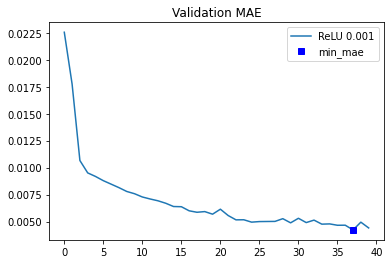

In [20]:
# colors = ['Red', 'Green']
i = 0
min = 1.0
min_epoch = 0
for experiment_id in mae.keys():
    plt.plot(mae[experiment_id], label=experiment_id)
    if np.min(mae[experiment_id]) < min:
        min = np.min(mae[experiment_id])
        min_epoch = mae[experiment_id].index(min)
    i += 1

plt.plot(min_epoch, min, 'bs', label = 'min_mae')
plt.legend()
plt.title('Validation MAE');
print(float(min), float(min_epoch))

0.005986605705154175 39.0


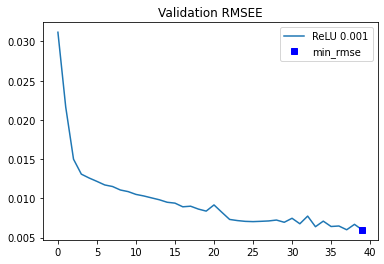

In [21]:
# colors = ['Red', 'Green']
i = 0
min = 1.0
min_epoch = 0
for experiment_id in rmse.keys():
    plt.plot(rmse[experiment_id], label=experiment_id)
    if np.min(rmse[experiment_id]) < min:
        min = np.min(rmse[experiment_id])
        min_epoch = rmse[experiment_id].index(min)
    i += 1
plt.plot(min_epoch, min, 'bs', label = 'min_rmse')
plt.legend()
plt.title('Validation RMSEE');
print(float(min), float(min_epoch))

In [22]:
ans = []
model = Model

X_test = X_test.to(device = 'cuda', dtype=torch.float)
model.eval()
pred = model(X_test)
y = (pred * 1000).to('cpu')
# print(pred)
ans.extend(y.detach().numpy())
torch.cuda.empty_cache()

In [23]:
# with open('/content/drive/MyDrive/SKI/Second_task/Dmitry_Novikov.csv', 'w') as csvfile:
#     csvwriter=csv.writer(csvfile)
#     for i in range(len(ans)):
#         csvwriter.writerow([ans[i]])

In [24]:
model = Model
X_train = X_train.to(device = 'cuda', dtype=torch.float)
Y_train = Y_train.to(device = 'cuda', dtype=torch.float)
model.eval()
pred = model(X_train)
loss = torch.nn.MSELoss()
print(loss(pred * 1000, Y_train * 1000))

tensor(6.6554, device='cuda:0', grad_fn=<MseLossBackward>)
